In [2]:
#default_exp visual

In [3]:
#export
from mytools.tools import *
import numpy as np
import torch
from matplotlib import pyplot as plt
import requests
import pandas as pd

In [4]:
#export
from matplotlib import pyplot as plt
import io
import seaborn as sb
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from PIL import Image
plt.rcParams['figure.figsize'] = (70,70)

In [5]:
#export
#https://stackoverflow.com/questions/59831211/neighbours-of-a-cell-in-matrix-pytorch
import torch.nn.functional as nnf

def mean_filter(x_bchw):
    """
    Calculating the mean of each 3x3 neighborhood.
    input:
    - x_bchw: input tensor of dimensions batch-channel-height-width
    output:
    - y_bchw: each element in y is the average of the 9 corresponding elements in x_bchw
    """
    # define the filter
    box = torch.ones((3, 3), dtype=x_bchw.dtype, device=x_bchw.device, requires_grad=False)  
    box = box / box.sum()
    box = box[None, None, ...].repeat(x_bchw.size(1), 1, 1, 1)
    # use grouped convolution - so each channel is averaged separately.  
    y_bchw = nnf.conv2d(x_bchw, box, padding=1, groups=x_bchw.size(1))
    return y_bchw

In [1]:
#export
def visualize_array(array,back_img = None,alpha=0.3,size = 500,colors = ["white","lime","green","yellow","orange", "red","purple"],values = [0,1,50,100,200,300,400],vmin=5):

    l = list(zip([v/max(values) for v in values],colors))
    cmap=LinearSegmentedColormap.from_list('hmap',l)
    if not array.T.shape == back_img.size:array = extrapolate(array,size = size)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    sb.heatmap(array, alpha=0.8,cmap=cmap,vmin=vmin, vmax=max(values),cbar=False)
    ax.imshow(back_img, interpolation='none', alpha=1)

    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return Image.open(buf)

In [7]:
#export
def extrapolate(t,factor=None,size=None):
    t     = torch.Tensor(t)
    t     = t.unsqueeze(0)
    t     = torch.nn.functional.upsample(t, scale_factor=factor,size=size)
    t     = t.squeeze(0).T.unsqueeze(0)
    t     = torch.nn.functional.upsample(t, scale_factor=factor,size=size)
    return  t.squeeze(0).T

In [8]:
#export
def expand_boundaries(t,times=5,factor=5):
    init_size = t.shape[0]
    t = extrapolate(t,factor=1/factor)
    t = t[None, None, ...].repeat(t.size(1), 1, 1, 1)
    for _ in range(times):
        t = mean_filter(t)
        t[t>0] = 1

    t = t[0,0,:]
    return extrapolate(t,size=init_size).numpy()

In [9]:
#export
def crop_center_arr(arr,shape):
    left  = int((arr.shape[1]-shape)/2)
    right =      left+shape  
    up    = int((arr.shape[0]-shape)/2)
    down  =      up+shape 
    return arr[left:right, up:down]

In [10]:
#export
def apply_mask(img,mask):
    mask = np.array(mask).astype('int')
    img = np.array(img)
    # if img[:,:,0].shape !=mask.shape: 
    #     df = pd.DataFrame([mask.shape,img.shape[:-1]])
    #     df.iloc[0] = -df.iloc[0]
    #     mask = mask[:-1,:] if df.sum().tolist() ==[0, -1]  else mask[:,:-1]
        
    
    return img * np.stack([mask]*3).T

In [11]:
#export
def crop_zeros(img_arr):

    true_points = np.argwhere(img_arr)
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    return (img_arr[top_left[0]:bottom_right[0]+1,
                      top_left[1]:bottom_right[1]+1]).astype(np.uint8)

In [58]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [246]:
#export
def crop_image_to_square(img):
    size = max(img.size)//2*2

    x_adj = int((img.size[0]-size)/2)
    y_adj = int((img.size[1]-size)/2)

    return img.crop((x_adj,y_adj,size+x_adj,size+y_adj))

In [250]:
#url = 'https://dima.grankin.eu/reference_images/AgACAgIAAxkBAAIKAmLhn0SdD55hleSPR5q57eb-6Lb2AAIZvzEb6jQQS7YEy1gu7EwnAQADAgADeQADKQQ'
url = 'https://image.shutterstock.com/z/stock-photo-healthy-lunch-box-with-sandwich-and-fresh-vegetables-bottle-of-water-and-fruits-on-wooden-568229575.jpg'

img = get_image_from_url(url)

In [251]:
img = crop_image_to_square(img)

In [252]:
img.size

(1500, 1500)

In [21]:
#export
def search_clip(url,foods,food_clips,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [22]:
photo_id=''

url = 'https://image.shutterstock.com/z/stock-photo-white-plate-of-orange-pumpkin-soup-on-the-table-studio-shot-1909804795.jpg'
img = get_image_from_url(url)
img = crop_image_to_square(img)
total_size = img.size[0]*img.size[1]

i = np.asarray(img, dtype="uint8")
i = np.flip(i,2)

In [23]:
s = 100
ones = torch.ones(s,s)
t = torch.zeros(1000,1000)
x=600
y=600
t[x:x+s,y:y+s] = ones
x=700
y=700
t[x:x+s,y:y+s] = ones

In [26]:
t.max()

tensor(1.)

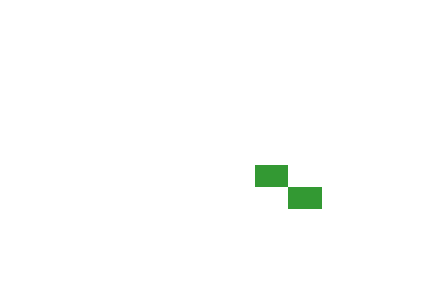

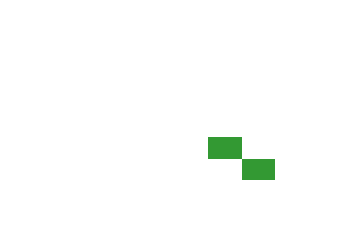

In [24]:
visualize_array(t)

In [31]:
tt = expand_boundaries(t,times=5,factor=5)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


In [32]:
tt

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

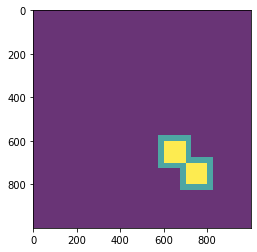

In [16]:
visualize_array(t.numpy()+tt)

In [3]:
!conda activate f4; nbdev_build_lib

Converted 00_custom_pandas.ipynb.
Converted 00_psql.ipynb.
Converted 00_tools.ipynb.
Converted 00_visual.ipynb.
Converted 02_onehot.ipynb.
Converted index.ipynb.
